In [101]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [102]:
# declarations
base_dir_data = "/ccb/salz8-1/avaraby/tx_noise/data/"
base_dir_out = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/GTEx_aggs/"
out_dir = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/sim_samples/"

readlen = 101
num_tissues = 3
num_samples = 10

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [3]:
# first load all annotations into containers for processing later
real_gtfs = [list() for x in range(num_tissues)]
splicing_gtfs = [list() for x in range(num_tissues)]
intronic_gtfs = [list() for x in range(num_tissues)]
intergenic_gtfs = [list() for x in range(num_tissues)]

for tissue_num in range(num_tissues):
    for sample_num in range(num_samples):
        real_gtfs[tissue_num].append(pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        splicing_gtfs[tissue_num].append(pd.read_csv(out_dir+"splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        intronic_gtfs[tissue_num].append(pd.read_csv(out_dir+"intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        intergenic_gtfs[tissue_num].append(pd.read_csv(out_dir+"intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".gtf",sep="\t",names=gff3cols))
        
        real_gtfs[tissue_num][-1] = real_gtfs[tissue_num][-1][real_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        splicing_gtfs[tissue_num][-1] = splicing_gtfs[tissue_num][-1][splicing_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        intronic_gtfs[tissue_num][-1] = intronic_gtfs[tissue_num][-1][intronic_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        intergenic_gtfs[tissue_num][-1] = intergenic_gtfs[tissue_num][-1][intergenic_gtfs[tissue_num][-1]["type"]=="transcript"].reset_index(drop=True)
        
        real_gtfs[tissue_num][-1]["lid"] = real_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        splicing_gtfs[tissue_num][-1]["lid"] = splicing_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intronic_gtfs[tissue_num][-1]["lid"] = intronic_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intergenic_gtfs[tissue_num][-1]["lid"] = intergenic_gtfs[tissue_num][-1].attributes.str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        
        real_gtfs[tissue_num][-1]["tid"] = real_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        splicing_gtfs[tissue_num][-1]["tid"] = splicing_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intronic_gtfs[tissue_num][-1]["tid"] = intronic_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intergenic_gtfs[tissue_num][-1]["tid"] = intergenic_gtfs[tissue_num][-1].attributes.str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        
        real_gtfs[tissue_num][-1]["tpm"] = real_gtfs[tissue_num][-1].attributes.str.split("sim_tpm=",expand=True,n=1)[1].str.split(";",expand=True,n=1)[0].astype(float)
        splicing_gtfs[tissue_num][-1]["tpm"] = splicing_gtfs[tissue_num][-1].attributes.str.split("sim_tpm=",expand=True,n=1)[1].str.split(";",expand=True,n=1)[0].astype(float)
        intronic_gtfs[tissue_num][-1]["tpm"] = intronic_gtfs[tissue_num][-1].attributes.str.split("sim_tpm=",expand=True,n=1)[1].str.split(";",expand=True,n=1)[0].astype(float)
        intergenic_gtfs[tissue_num][-1]["tpm"] = intergenic_gtfs[tissue_num][-1].attributes.str.split("sim_tpm=",expand=True,n=1)[1].str.split(";",expand=True,n=1)[0].astype(float)

In [4]:
num_locs_tissue_real = list()
num_locs_tissue_intergenic = list()

num_locs_sample_real = list()
num_locs_sample_intergenic = list()

num_txs_sample_real = list()
num_txs_sample_splicing = list()
num_txs_sample_intronic = list()
num_txs_sample_intergenic = list()

for tissue_num in range(num_tissues):
    nltr = set() # num_locs_tissue_real
    nlti = set() # num_locs_tissue_intergenic
    for sample_num in range(num_samples):
        nlsr = set()
        nlsr = nlsr.union(set(real_gtfs[tissue_num][sample_num]["lid"]))
        nlsr = nlsr.union(set(splicing_gtfs[tissue_num][sample_num]["lid"]))
        nlsr = nlsr.union(set(intronic_gtfs[tissue_num][sample_num]["lid"]))
        nlsi = set(intergenic_gtfs[tissue_num][sample_num]["lid"])
        
        nltr = nltr.union(nlsr)
        nlti = nlti.union(nlsi)
        
        num_locs_sample_real.append(len(nlsr))
        num_locs_sample_intergenic.append(len(nlsi))
        
        num_txs_sample_real.append(len(real_gtfs[tissue_num][sample_num]["tid"]))
        num_txs_sample_splicing.append(len(splicing_gtfs[tissue_num][sample_num]["tid"]))
        num_txs_sample_intronic.append(len(intronic_gtfs[tissue_num][sample_num]["tid"]))
        num_txs_sample_intergenic.append(len(intergenic_gtfs[tissue_num][sample_num]["tid"]))
        
    num_locs_tissue_real.append(len(nltr))
    num_locs_tissue_intergenic.append(len(nlti))

In [49]:
t_loc = pd.read_csv(base_dir_out+"res.num_locs_tissue")
# now we shall remove any outliers from the data
q25,q50,q75 = t_loc['real'].quantile([0.25,0.5,0.75])
iqr = q75-q25
thw = q75+1.5*iqr
tlw = q25-1.5*iqr
ahw = t_loc[t_loc["real"]<=thw]["real"].max()
alw = t_loc[t_loc["real"]>=tlw]["real"].min()
t_loc = t_loc[(t_loc['real']<=ahw)&(t_loc['real']>=alw)]

q25,q50,q75 = t_loc['intergenic'].quantile([0.25,0.5,0.75])
iqr = q75-q25
thw = q75+1.5*iqr
tlw = q25-1.5*iqr
ahw = t_loc[t_loc["intergenic"]<=thw]["intergenic"].max()
alw = t_loc[t_loc["intergenic"]>=tlw]["intergenic"].min()
t_loc = t_loc[(t_loc['intergenic']<=ahw)&(t_loc['intergenic']>=alw)]
t_loc.columns = ["Real","Intergenic"]
t_loc = pd.DataFrame(t_loc.stack()).reset_index().drop("level_0",axis=1)
t_loc.columns = ["Gene Type","Number of Genes"]
t_loc["Dataset"] = "GTEx"
num_locs_tissue_sim = pd.concat([pd.DataFrame(num_locs_tissue_real,columns=["Real"]),\
                                 pd.DataFrame(num_locs_tissue_intergenic,columns=["Intergenic"])],axis=1)
num_locs_tissue_sim = pd.DataFrame(num_locs_tissue_sim.stack()).reset_index().drop("level_0",axis=1)
num_locs_tissue_sim.columns = ["Gene Type","Number of Genes"]
num_locs_tissue_sim["Dataset"] = "Simulated"
res_tloc_df = pd.concat([t_loc,num_locs_tissue_sim],axis=0).reset_index(drop=True)
res_tloc_df

,Gene Type,Number of Genes,Dataset
0,Real,28247,GTEx
1,Intergenic,13784,GTEx
2,Real,34130,GTEx
3,Intergenic,77307,GTEx
4,Real,29391,GTEx
...,...,...,...
59,Intergenic,9623,Simulated
60,Real,29494,Simulated
61,Intergenic,10153,Simulated
62,Real,25802,Simulated


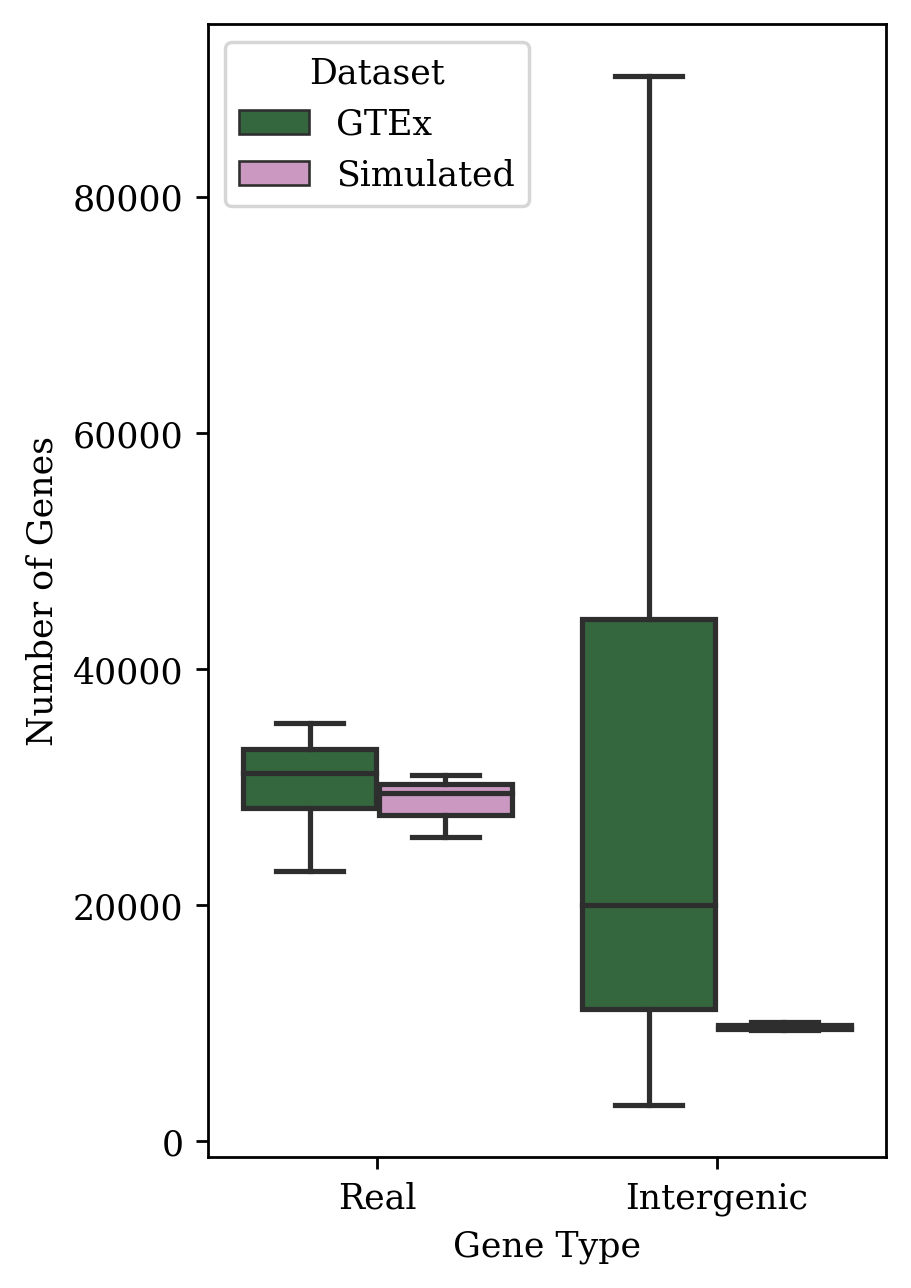

In [143]:
fig = plt.figure(figsize=(3.5,6),dpi=250)
ax = sns.boxplot(x="Gene Type",y="Number of Genes",hue="Dataset",data=res_tloc_df,palette="cubehelix")
# ax.set_title("Number of Genes per Tissue in GTEx\nand Simulated Datasets")
ax.set_xlabel("Gene Type")
ax.set_ylabel("Number of Genes")
plt.show()

In [60]:
s_loc = pd.read_csv(base_dir_out+"res.num_locs_sample")
s_loc = s_loc[["all_real","intergenic"]]
s_loc.columns = ["Real","Intergenic"]
q25,q50,q75 = s_loc['Real'].quantile([0.25,0.5,0.75])
iqr = q75-q25
thw = q75+1.5*iqr
tlw = q25-1.5*iqr
ahw = s_loc[s_loc["Real"]<=thw]["Real"].max()
alw = s_loc[s_loc["Real"]>=tlw]["Real"].min()
s_loc = s_loc[(s_loc['Real']<=ahw)&(s_loc['Real']>=alw)]

q25,q50,q75 = s_loc['Intergenic'].quantile([0.25,0.5,0.75])
iqr = q75-q25
thw = q75+1.5*iqr
tlw = q25-1.5*iqr
ahw = s_loc[s_loc["Intergenic"]<=thw]["Intergenic"].max()
alw = s_loc[s_loc["Intergenic"]>=tlw]["Intergenic"].min()
s_loc = s_loc[(s_loc['Intergenic']<=ahw)&(s_loc['Intergenic']>=alw)]
s_loc = pd.DataFrame(s_loc.stack()).reset_index().drop("level_0",axis=1)
s_loc.columns = ["Gene Type","Number of Genes"]
s_loc["Dataset"] = "GTEx"

num_locs_sample_sim = pd.concat([pd.DataFrame(num_locs_sample_real,columns=["Real"]),\
                                 pd.DataFrame(num_locs_sample_intergenic,columns=["Intergenic"])],axis=1)
num_locs_sample_sim = pd.DataFrame(num_locs_sample_sim.stack()).reset_index().drop("level_0",axis=1)
num_locs_sample_sim.columns = ["Gene Type","Number of Genes"]
num_locs_sample_sim["Dataset"] = "Simulated"
res_sloc_df = pd.concat([s_loc,num_locs_sample_sim],axis=0).reset_index(drop=True)
res_sloc_df

,Gene Type,Number of Genes,Dataset
0,Real,12656,GTEx
1,Intergenic,892,GTEx
2,Real,14990,GTEx
3,Intergenic,1061,GTEx
4,Real,14994,GTEx
...,...,...,...
17105,Intergenic,1231,Simulated
17106,Real,16529,Simulated
17107,Intergenic,1297,Simulated
17108,Real,15899,Simulated


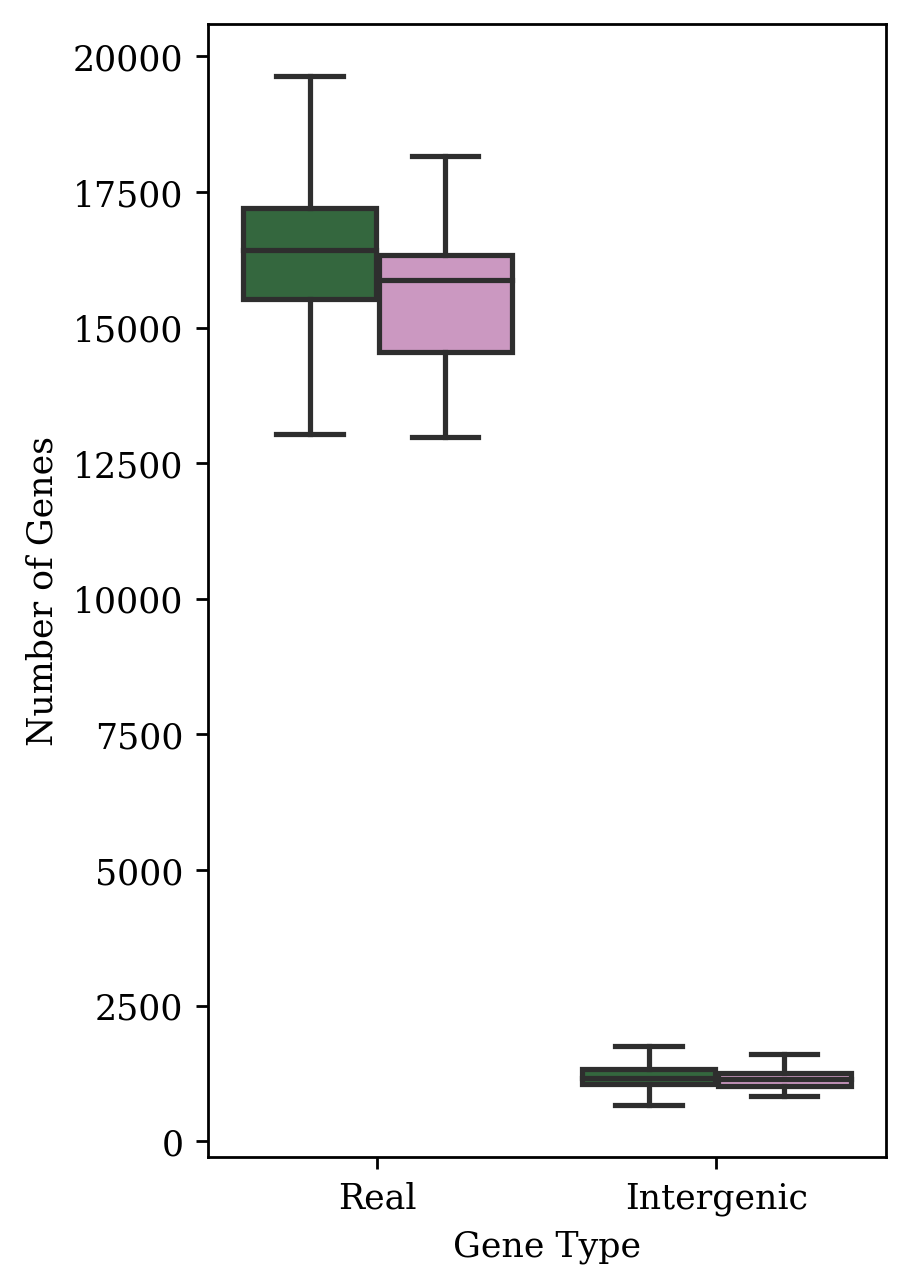

In [142]:
fig = plt.figure(figsize=(3.5,6),dpi=250)
ax = sns.boxplot(x="Gene Type",y="Number of Genes",hue="Dataset",data=res_sloc_df,palette="cubehelix",showfliers=False)
# ax.set_title("Number of Genes per Sample in GTEx\nand Simulated Datasets")
ax.set_xlabel("Gene Type")
ax.set_ylabel("Number of Genes")
ax.legend().remove()
plt.show()

In [134]:
tx_ns = pd.read_csv(base_dir_out+"res.num_tx_per_sample")
tx_ns = tx_ns[["real","splicing","intronic","intergenic"]]
tx_ns.columns = ["Real","Splicing","Intronic","Intergenic"]
tx_ns = pd.DataFrame(tx_ns.stack()).reset_index().drop("level_0",axis=1)
tx_ns.columns = ["Transcript Type","Number of Transcripts"]
tx_ns["Dataset"] = "GTEx"

num_txs_sample_sim = pd.concat([pd.DataFrame(num_txs_sample_real,columns=["Real"]),\
                                pd.DataFrame(num_txs_sample_splicing,columns=["Splicing"]),\
                                pd.DataFrame(num_txs_sample_intronic,columns=["Intronic"]),\
                                pd.DataFrame(num_txs_sample_intergenic,columns=["Intergenic"])],axis=1)
num_txs_sample_sim = pd.DataFrame(num_txs_sample_sim.stack()).reset_index().drop("level_0",axis=1)
num_txs_sample_sim.columns = ["Transcript Type","Number of Transcripts"]
num_txs_sample_sim["Dataset"] = "Simulated"
res_stx_df = pd.concat([tx_ns,num_txs_sample_sim],axis=0).reset_index(drop=True)
res_stx_df

,Transcript Type,Number of Transcripts,Dataset
0,Real,34934,GTEx
1,Splicing,11466,GTEx
2,Intronic,686,GTEx
3,Intergenic,2359,GTEx
4,Real,37928,GTEx
...,...,...,...
39295,Intergenic,1305,Simulated
39296,Real,25416,Simulated
39297,Splicing,11442,Simulated
39298,Intronic,1936,Simulated


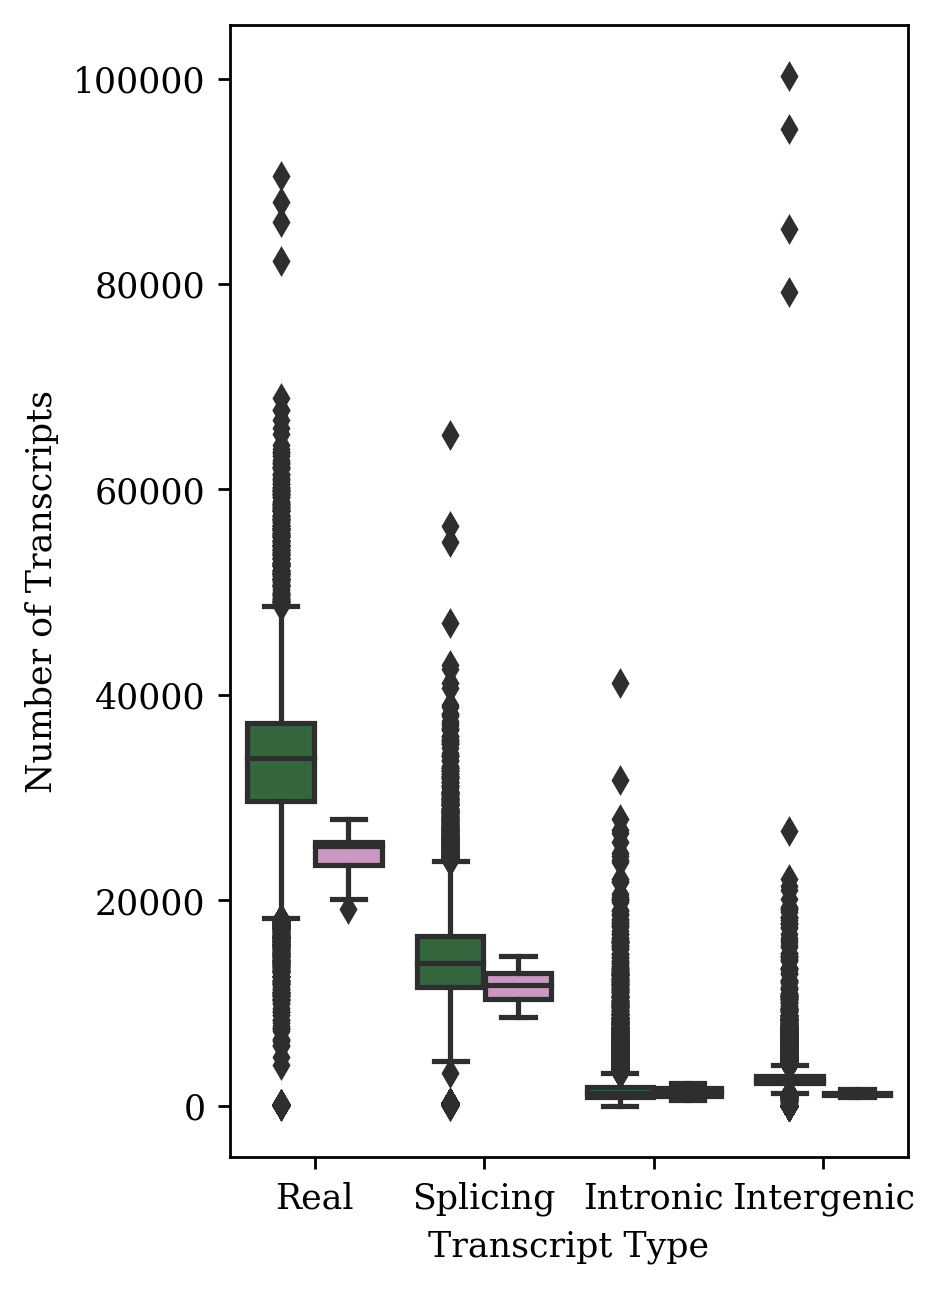

In [141]:
fig = plt.figure(figsize=(3.5,6),dpi=250)
ax = sns.boxplot(x="Transcript Type",y="Number of Transcripts",hue="Dataset",data=res_stx_df,palette="cubehelix",showfliers=True)
# ax.set_title("Number of Transcripts per Sample in GTEx\nand Simulated Datasets")
ax.set_xlabel("Transcript Type")
ax.set_ylabel("Number of Transcripts")
ax.legend().remove()
plt.show()

In [72]:
frac_real_sample = []
frac_real_locs = []

total_real_locs = []
total_noise_locs = []

for tissue_num in range(num_tissues):
    for sample_num in range(num_samples):
        sum_real = real_gtfs[tissue_num][sample_num]["tpm"].sum()
        sum_splicing = splicing_gtfs[tissue_num][sample_num]["tpm"].sum()
        sum_intronic = intronic_gtfs[tissue_num][sample_num]["tpm"].sum()
        sum_intergenic = intergenic_gtfs[tissue_num][sample_num]["tpm"].sum()
        frac_real_sample.append((sum_real/(sum_real+sum_splicing+sum_intronic+sum_intergenic))*100.0)
        
        realg = real_gtfs[tissue_num][sample_num][["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
        realg.columns = ["lid","tpm_real"]
        splicingg = splicing_gtfs[tissue_num][sample_num][["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
        splicingg.columns = ["lid","tpm_splicing"]
        intronicg = intronic_gtfs[tissue_num][sample_num][["lid","tpm"]].groupby(by="lid").agg({"tpm":"sum"}).reset_index()
        intronicg.columns = ["lid","tpm_intronic"]
        joined = realg.merge(splicingg,on="lid",how="outer",indicator=True)
        joined["tpm_real"] = joined["tpm_real"].fillna(0)
        joined.drop("_merge",axis=1,inplace=True)
        joined = joined.merge(intronicg,on="lid",how="outer",indicator=True)
        joined["tpm_real"] = joined["tpm_real"].fillna(0)
        joined.drop("_merge",axis=1,inplace=True)
        joined["tpm_splicing"] = joined.tpm_splicing.fillna(0)
        joined["tpm_intronic"] = joined.tpm_intronic.fillna(0)
        joined["tpm_total"] = joined.tpm_real+joined.tpm_splicing+joined.tpm_intronic
        joined["frac_tpm_real"] = joined.tpm_real/joined.tpm_total
        joined["total_tpm_noise"] = joined["tpm_splicing"]+joined["tpm_intronic"]
        
        frac_real_locs.extend(joined["frac_tpm_real"].tolist())
        total_real_locs.extend(joined["tpm_real"].tolist())
        total_noise_locs.extend(joined["total_tpm_noise"].tolist())

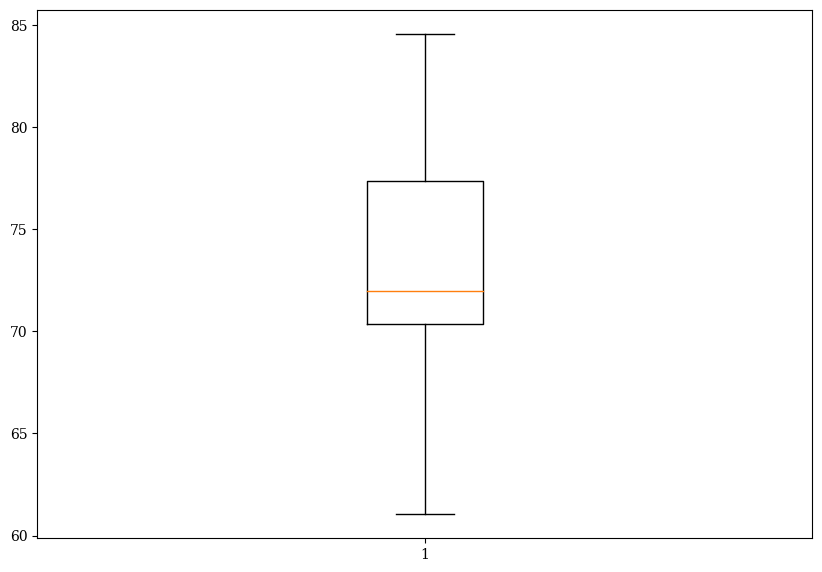

In [73]:
frac_real_sample_df = pd.DataFrame(frac_real_sample,columns=["frac_real"])
fig = plt.subplots(figsize=(10,7),dpi=100)
plt.boxplot(frac_real_sample_df.T)
plt.show()

In [75]:
stats_loc5 = pd.read_csv(base_dir_out+"res.num_tx_per_sample_loc5")
stats_loc5_nt = stats_loc5[["sample","real","splicing","intronic","intergenic"]]
stats_loc5 = stats_loc5[["total_tpm_real","total_tpm_splicing","total_tpm_intronic","total_tpm_intergenic"]]
stats_loc5["tpm_total"] = stats_loc5.total_tpm_real+stats_loc5.total_tpm_splicing+stats_loc5.total_tpm_intronic
stats_loc5["frac_tpm_real"] = stats_loc5.total_tpm_real/stats_loc5.tpm_total
stats_loc5["total_tpm_noise"] = stats_loc5["total_tpm_splicing"]+stats_loc5["total_tpm_intronic"]
stats_loc5.head()

,total_tpm_real,total_tpm_splicing,total_tpm_intronic,total_tpm_intergenic,tpm_total,frac_tpm_real,total_tpm_noise
0,0.00000,4.92635,0.0,0.0,4.92635,0.0,4.92635
1,2.88853,0.00000,0.0,0.0,2.88853,1.0,0.00000
2,2.61178,0.00000,0.0,0.0,2.61178,1.0,0.00000
3,0.00000,1.58056,0.0,0.0,1.58056,0.0,1.58056
4,7.63499,0.00000,0.0,0.0,7.63499,1.0,0.00000


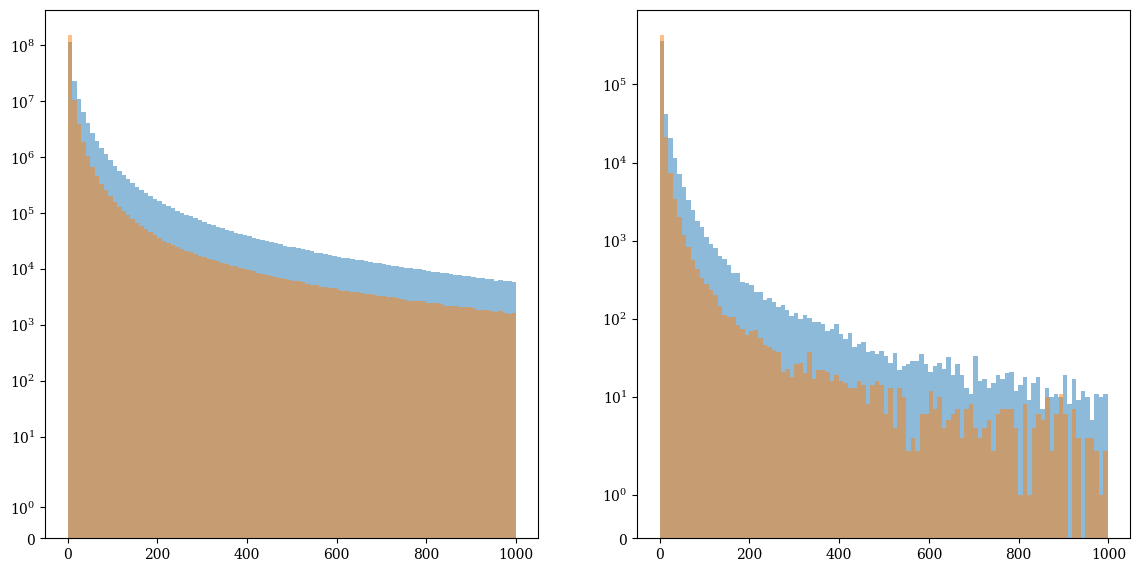

In [34]:
total_locs = pd.concat([pd.DataFrame(total_real_locs,columns=["real"]),\
                        pd.DataFrame(total_noise_locs,columns=["noise"])],axis=1)

fig1, axes = plt.subplots(ncols=2,nrows=1,figsize=(14,7),dpi=100)
axes[0].hist(stats_loc5[(stats_loc5["total_tpm_real"]<1000)]["total_tpm_real"],bins=100,alpha=0.5,label='real')
axes[0].hist(stats_loc5[(stats_loc5["total_tpm_noise"]<1000)]["total_tpm_noise"],bins=100,alpha=0.5,label='noise')
axes[0].set_yscale("symlog")

axes[1].hist(total_locs[(total_locs["real"]<1000)]["real"],bins=100,alpha=0.5,label='real')
axes[1].hist(total_locs[(total_locs["noise"]<1000)]["noise"],bins=100,alpha=0.5,label='noise')
axes[1].set_yscale("symlog")

plt.show()

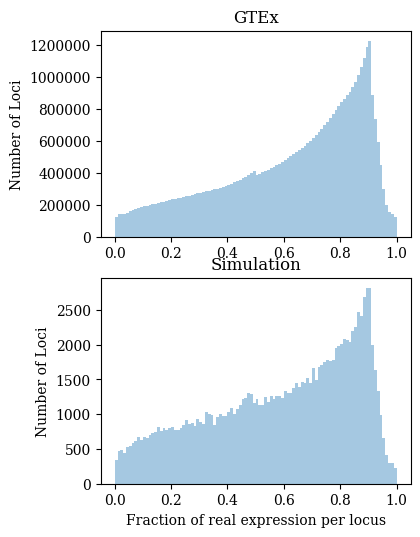

In [128]:
frac_locs = pd.DataFrame(frac_real_locs,columns=["frac_real"])

fig1, axes = plt.subplots(ncols=1,nrows=2,figsize=(4,6),dpi=100)
# axes[0].hist(stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&(stats_loc5["frac_tpm_real"]>0.0)]["frac_tpm_real"],bins=100,alpha=0.5,label='frac_real')
sns.distplot(stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&\
                        (stats_loc5["frac_tpm_real"]>0.0)]["frac_tpm_real"],bins=100,label='frac_real',kde=False,ax=axes[0]);
# axes[1].hist(frac_locs[(frac_locs["frac_real"]<1.0)&(frac_locs["frac_real"]>0.0)]["frac_real"],bins=100,alpha=0.5,label='frac_real')
sns.distplot(frac_locs[(frac_locs["frac_real"]<1.0)&(frac_locs["frac_real"]>0.0)]["frac_real"],bins=100,kde=False,ax=axes[1]);
axes[0].set_title("GTEx")
axes[0].set_ylabel("Number of Loci")
axes[0].set_xlabel("")
axes[1].set_title("Simulation")
axes[1].set_xlabel("Fraction of real expression per locus")
axes[1].set_ylabel("Number of Loci")
# plt.suptitle("Fraction of Expression\nFrom Annotated Transcripts per Gene")
plt.show()

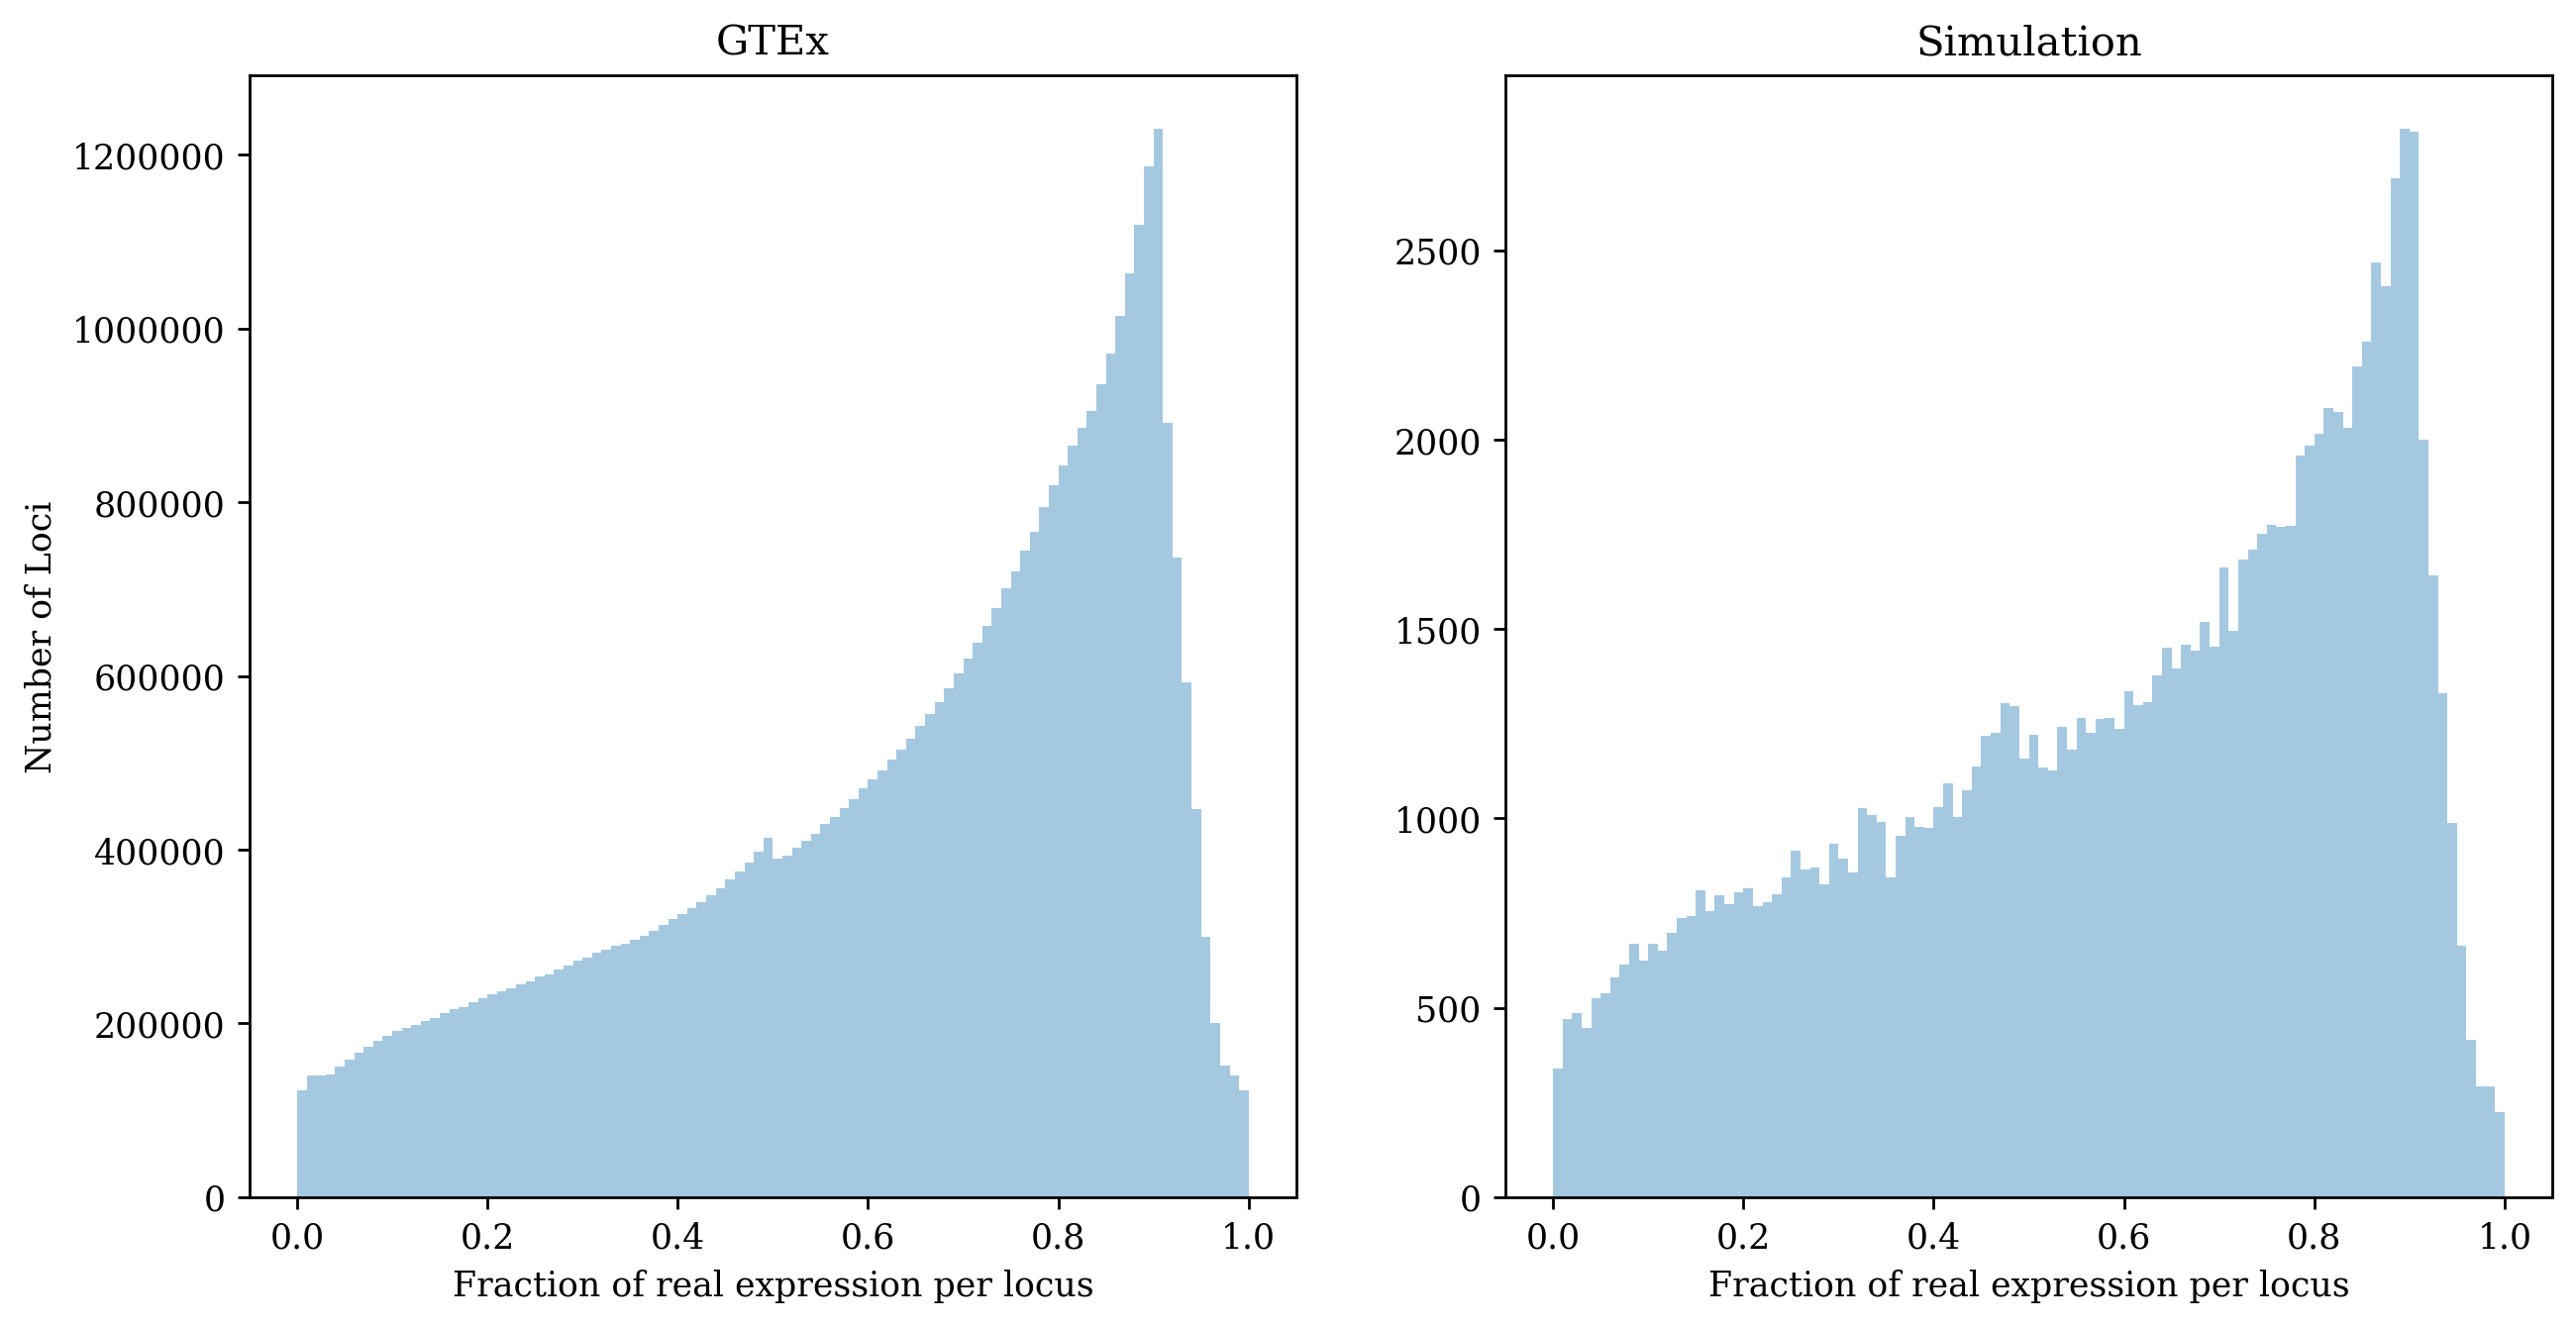

In [139]:
# frac_locs = pd.DataFrame(frac_real_locs,columns=["frac_real"])

fig1, axes = plt.subplots(ncols=2,nrows=1,figsize=(12,6),dpi=250)
# axes[0].hist(stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&(stats_loc5["frac_tpm_real"]>0.0)]["frac_tpm_real"],bins=100,alpha=0.5,label='frac_real')
sns.distplot(stats_loc5[(stats_loc5["frac_tpm_real"]<1.0)&\
                        (stats_loc5["frac_tpm_real"]>0.0)]["frac_tpm_real"],bins=100,label='frac_real',kde=False,ax=axes[0]);
# axes[1].hist(frac_locs[(frac_locs["frac_real"]<1.0)&(frac_locs["frac_real"]>0.0)]["frac_real"],bins=100,alpha=0.5,label='frac_real')
sns.distplot(frac_locs[(frac_locs["frac_real"]<1.0)&(frac_locs["frac_real"]>0.0)]["frac_real"],bins=100,kde=False,ax=axes[1]);
axes[0].set_title("GTEx")
axes[0].set_ylabel("Number of Loci")
axes[0].set_xlabel("Fraction of real expression per locus")
axes[1].set_title("Simulation")
axes[1].set_xlabel("Fraction of real expression per locus")
axes[1].set_ylabel("")
# plt.suptitle("Fraction of Expression\nFrom Annotated Transcripts per Gene")
plt.show()

In [ ]:
# need counts of transcripts and loci in the original dataset
